# Special Topics in Computer Science: Image Classification with CNNs

### **INT3121 20**   -----  4-6 Wednesday 210GD3

## Diep Ng., Ph.D. 
Mail-to: ngocdiep at vnu.edu.vn

# Week 1: Introduction

Dataset: CIFAR-10 http://www.cs.toronto.edu/~kriz/cifar.html

- 60,000 tiny images
    + training set: 50,000 images
    + test set: 10,000 images
- size: 32x32 pixels
- Each image is labeled with one of 10 classes
- 10 classes: *airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck*
- State-of-the-art accuracy: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

<img src="w1_cifar10_sota.png" width="600">



## 1. Download the dataset
- Either download directly from the website
- Using interface provided by keras


In [9]:
from keras.datasets import cifar10

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 44s 0us/step


In [11]:
x_train.shape

(50000, 32, 32, 3)

In [12]:
y_train.shape

(50000, 1)

## 2. Explore the data

In [13]:
# count the number images of each class
from collections import Counter

counter = Counter(y_train.ravel())
counter

Counter({6: 5000,
         9: 5000,
         4: 5000,
         1: 5000,
         2: 5000,
         7: 5000,
         8: 5000,
         3: 5000,
         5: 5000,
         0: 5000})

In [14]:
Counter(y_test.ravel())

Counter({3: 1000,
         8: 1000,
         0: 1000,
         6: 1000,
         1: 1000,
         9: 1000,
         5: 1000,
         7: 1000,
         4: 1000,
         2: 1000})

### Homework: Find the corresponding label names of target classes

In [15]:
%matplotlib inline

In [16]:
import matplotlib.pyplot as plt

In [17]:
plt.rcParams['figure.figsize'] = [10, 8]

In [18]:
def draw_samples(X, y, start_id, rows=4, cols=4, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[start_id+i].reshape(32,32,3)
        plt.imshow(im)
        plt.title("Class {}".format(y[start_id+i]), fontsize=fontsize)
        plt.axis('off')

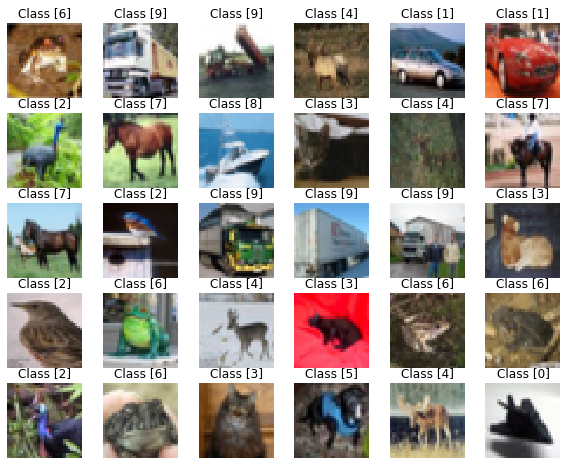

In [19]:
draw_samples(x_train, y_train, 0, 5, 6)

## 3. Classical solution: Image classification using distance similarity, AKA Nearest neighbors

Reference: http://cs231n.github.io/classification/

Two images $I_1$ and $I_2$, the $L_1$ distance is:

$d(I_1, I_2) = \sum_{p}{|I_1^p - I_2^p|}$

Two images are subtracted elementwise and then all differences are added up to a single number. If two images are identical, the result with be zero. But if the images are very different the result will be large.

<img src="w1_nn.jpeg" width="600">


In [20]:
x_train_rows = x_train.reshape(x_train.shape[0], 32*32*3)
x_test_rows = x_test.reshape(x_test.shape[0], 32*32*3)

In [21]:
import numpy as np

class NearestNeighbor(object):

    def train(self, xs, ys):
        """ xs is N x D where each row is an example. ys is 1-dimension of size N """
        # just remember the training data
        self.xs = xs
        self.ys = ys

    def predict(self, xs):
        """ xs is N x D where each row is an example we wish to predict label for """
        num_test = xs.shape[0]
        #prepare the result list
        y_pred = np.zeros(num_test, dtype = self.ys.dtype)

        # loop over all test rows
        for i in range(num_test):
            # find the nearest training image to the i'th test image
            # using the L1 distance (sum of absolute value differences)
            distances = np.sum(np.abs(self.xs - xs[i,:]), axis = 1)
            min_index = np.argmin(distances) # get the index with smallest distance
            y_pred[i] = self.ys[min_index] # predict the label of the nearest example

        return y_pred

In [22]:
import time

start = time.time()

#train and test
nn = NearestNeighbor()
nn.train(x_train_rows, y_train)
y_pred = nn.predict(x_test_rows[:100])

print("Predict time: ", time.time() - start)
# calculate the accurarcy
print("Accuracy: ", np.mean(y_pred == y_test[:100]))  #about 38.6%

Predict time:  41.08642816543579
Accuracy:  0.1021


## 4. Image classification using SVM classifier


Reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

<img src="w1_svm.png" width="600">

In [25]:
from sklearn.svm import SVC

start = time.time()
clf = SVC()
clf.fit(x_train_rows[:1000], y_train[:1000])

print("Training time: ", time.time() - start)



/Users/chupi/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chupi/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training time:  4.862126111984253


In [26]:
start = time.time()
y_pred = clf.predict(x_test_rows[:100])
print("Predicting/Testing time: ", time.time() - start)

Predicting/Testing time:  0.3030369281768799


In [30]:
score = clf.score(x_test_rows, y_test)

In [31]:
print("Score: ", score)

Score:  0.1


## 5. Image classification with a convolutional neural network

In [32]:
#import everything needed

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

#just to be sure, reload the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("x_train shape: {}, y_train shape: {}".format(x_train.shape, y_train.shape))
print("{} train samples, {} test samples".format(x_train.shape[0], x_test.shape[0]))

x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)
50000 train samples, 10000 test samples


In [33]:
#Convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [35]:
#build a model
# reference: https://keras.io/examples/cifar10_cnn/
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



In [36]:
# train the model

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

start = time.time()
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1
)

print("training time: ", time.time() - start)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 346s 9ms/step - loss: 1.8804 - acc: 0.3112 - val_loss: 1.6046 - val_acc: 0.4272
Epoch 2/10
40000/40000 [==============================] - 346s 9ms/step - loss: 1.5727 - acc: 0.4274 - val_loss: 1.4489 - val_acc: 0.4838
Epoch 3/10
40000/40000 [==============================] - 346s 9ms/step - loss: 1.4318 - acc: 0.4812 - val_loss: 1.3294 - val_acc: 0.5319
Epoch 4/10
40000/40000 [==============================] - 346s 9ms/step - loss: 1.3392 - acc: 0.5193 - val_loss: 1.2298 - val_acc: 0.5689
Epoch 5/10
40000/40000 [==============================] - 342s 9ms/step - loss: 1.2582 - acc: 0.5516 - val_loss: 1.1995 - val_acc: 0.5792
Epoch 6/10
40000/40000 [==============================] - 335s 8ms/step - loss: 1.1895 - acc: 0.5788 - val_loss: 1.1470 - val_acc: 0.5999
Epoch 7/10
40000/40000 [==============================] - 335s 8ms/step - loss: 1.1262 - acc: 0.6040 - val_loss: 1.0393 - 

In [37]:
# plot the history training
def plot_train_val(history, value="loss"):
    """Print loss or accuracy
    "loss" or "acc"
    """
    train_value = history.history[value]
    val_value = history.history["val_"+value]

    epochs = range(1, len(train_value) + 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, train_value, 'r+', label='Training %s' % value)
    # b is for "solid blue line"
    plt.plot(epochs, val_value, 'b', label='Validation %s' % value)
    plt.title('Training and validation %s' % value)
    plt.xlabel('Epochs')
    plt.ylabel(value)
    plt.legend()

    plt.show()


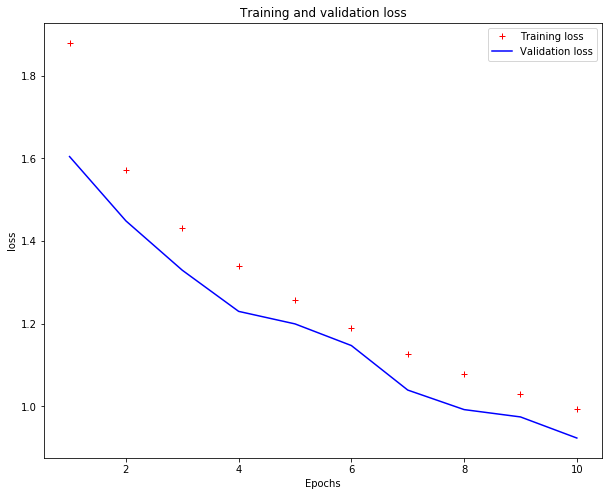

In [38]:
plot_train_val(history, "loss")

In [39]:
start = time.time()
score, acc = model.evaluate(x_test, y_test, batch_size=32)
print("Evaluation time: ", time.time() - start)
print("Score/accuracy: ", score, acc)

10000/10000 [==============================] - 29s 3ms/step
Evaluation time:  28.608904123306274
Score/accuracy:  0.9207898648262024 0.6836


# Homeworks:

1. Install all necessary environments: keras, tensorflow, python3, jupyter notebook, numpy, sklearn
    
    Recommend to use anaconda for installation
2. Re-run all the scripts
3. Obtain the label names of classes
4. Given an image, predict the label of the image